In [1]:
import pandas as pd
import numpy as np

import sepplotlib as spl
from views_dataviz.map import mapper, utils
from views_dataviz import color

import sqlalchemy as sa
import geopandas as gpd
from ingester3.config import source_db_path

engine = sa.create_engine(source_db_path)
gdf = gpd.GeoDataFrame.from_postgis(
    "SELECT id, geom FROM prod.country WHERE in_africa=1", engine, geom_col='geom'
)
gdf = gdf.to_crs(4326) 
gdf["preds"] = np.random.uniform(low=0, high=1, size=len(gdf))
gdf["month_id"] = 500

In [2]:
n = 100
np.random.seed(1962)

mock = pd.DataFrame(
    {
        "y_true": np.concatenate(
            [
                np.random.choice([0, 1], size=(int(n / 4),), p=p) 
                for p in ([0.9, 0.1], [0.6, 0.4], [0.4, 0.6], [0.1, 0.9])
            ]
        ),
        "y_pred_a": np.arange(0, 0.9, 0.9 / n) + np.random.uniform(0, 0.1, n),
        "y_pred_b": np.random.uniform(0, 1, n),
        "id": list(gdf.id.values[0:50]) + list(gdf.id.values[0:50])
    }
)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable  # type: ignore
from views_dataviz.map.presets import ViewsMap
from matplotlib.patches import ConnectionPatch

class ModelCriticismMap(spl.ModelCriticismPlot):
    """
    Extends ModelCriticismPlot with a mapping method.
    Overrides original labelling method.
    
    Attributes
    ----------
    df: 
    
    """
    
    def __init__(
        self,
        df,
        y_true,
        y_pred,
        lab,
        title,
        map_kwargs,
        n_worst
    ):
        super().__init__(
            df, 
            y_true, 
            y_pred, 
            lab, 
            title=title,
            n_worst=n_worst,
        )
        self.set_map_ax()
        self.mapper = ViewsMap(
            figure=(self.fig, self.map_ax), **map_kwargs
        )
        
    def annotate(self):
        pass  # Suppress original annotation method.
    
    def set_map_ax(self):
        """Add an ax for the map."""
        self.map_ax = self.fig.add_axes([1.1, 0, 1.1, 1])
        self.map_ax.tick_params(
            top=False,
            bottom=False,
            left=False,
            right=False,
            labelleft=False,
            labelbottom=False,
        )
        for axis in ["top", "bottom", "left", "right"]:
            self.map_ax.spines[axis].set_linewidth(self.framesize)
            
    def plot_map_layer(self, **kwargs):
        self.mapper.add_layer(**kwargs)
        self.mapper.cax.remove()  # Remove default colorbar.
        return self
        
    def connect(self):
        """
        Finds the appropriate map coordinate by matching labs.
        """
        for idx, row in self.df.loc[self.df.worst_fp == 1].iterrows():
            # For some reason geopandas loses some information when queried.
            mapindex = gdf.loc[gdf[self.lab] == row[self.lab]].index[0]
            mapcoord = gdf.loc[mapindex].geom.centroid.coords[0]
            con = ConnectionPatch(
                xyA=(1 + self.pad, idx),
                xyB=mapcoord,
                coordsA="data",
                coordsB="data",
                axesA=self.axs[0],
                axesB=self.map_ax,
                color=row["fgcolor"],
                #alpha=0.5
            )
            self.map_ax.add_artist(con)
        for idx, row in self.df.loc[self.df.worst_fn == 1].iterrows():
            mapindex = gdf.loc[gdf[self.lab] == row[self.lab]].index[0]
            mapcoord = gdf.loc[mapindex].geom.centroid.coords[0]
            con = ConnectionPatch(
                xyA=(1 + self.pad, idx),
                xyB=mapcoord,
                coordsA="data",
                coordsB="data",
                axesA=self.axs[0],
                axesB=self.map_ax,
                color=row["fgcolor"],
                #alpha=0.5
            )
            self.map_ax.add_artist(con)

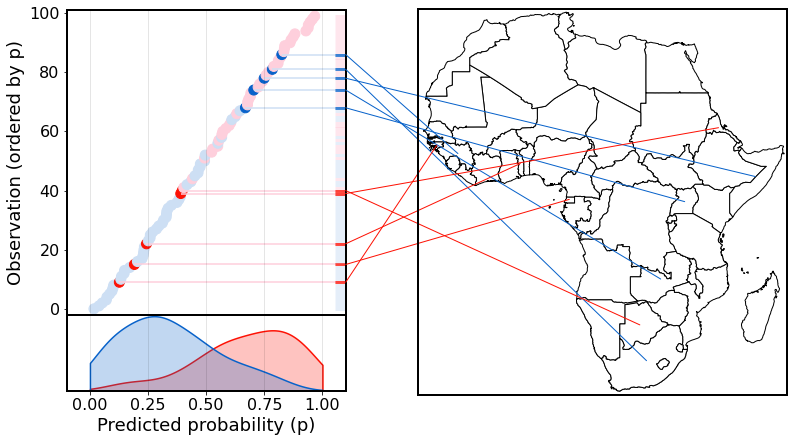

In [4]:
o = ModelCriticismMap(
    df=mock, 
    y_true="y_true", 
    y_pred="y_pred_a", 
    lab="id",
    title="",
    map_kwargs={"bbox": "africa"},
    n_worst=5,
).plot_map_layer(
    gdf=gdf, 
    suppress_textbox=True, 
    edgecolor="black",
    color="white",
).connect()